<a href="https://colab.research.google.com/github/mjvakili/MLcourse/blob/master/day4/GP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Gaussian Process

Consider a set of functions $\{f(x)\}$ that are drawn from a Gaussian distribution. Remember that a Gaussian distribution can be uniquely detrmined by its mean and its variance. 

For simplicity let's assume that the mean of these functions is zero. We will go back to this point later.

$\langle f(x) \rangle$ = 0

Then we need to specify the covariance of this Gaussian distribution:

$\langle f(x) f(x^\prime)\rangle = k(x, x^\prime)$, k is called the ***kernel*** of the Gaussian Process. 

A Gaussian Process defines a prior probability distribution over the space of functions. That is, prior to any observation, functions are drawn from a Gaussian probability with a covariance equal to the kernel $k(x, x^\prime)$.

Common choices of GP kernels are the following:

Squared exponential kernel: $k(x, x^\prime) = \exp\big(\frac{-(x-x^\prime)^2}{2l^2}\big)$; where $l$ is the length scale of the function. 

Squared kernel: $k(x, x^\prime) = \exp\big(\frac{-(x-x^\prime)}{l}\big)$, where $l$ is the length scale of the function. 

For a full list of Gaussian Process kernels, refer to this link [kernel cookbook](https://www.cs.toronto.edu/~duvenaud/cookbook/) and [george kernel documentation](http://dfm.io/george/current/user/kernels/).

In [1]:
!pip install george

    Running setup.py install for george ... done


In [0]:
import george
from george.kernels import ExpSquaredKernel
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['xtick.major.size'] = 7
matplotlib.rcParams['xtick.labelsize'] = 'x-large'
matplotlib.rcParams['ytick.major.size'] = 7
matplotlib.rcParams['ytick.labelsize'] = 'x-large'
matplotlib.rcParams['xtick.top'] = False
matplotlib.rcParams['ytick.right'] = False
matplotlib.rcParams['ytick.direction'] = 'in'
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['font.size'] = 15
matplotlib.rcParams['figure.figsize'] = [7,7]

In [0]:
# Set up a Gaussian process
kernel = ExpSquaredKernel(1.0)
gp = george.GP(kernel)

Text(0, 0.5, '$f(x)$')

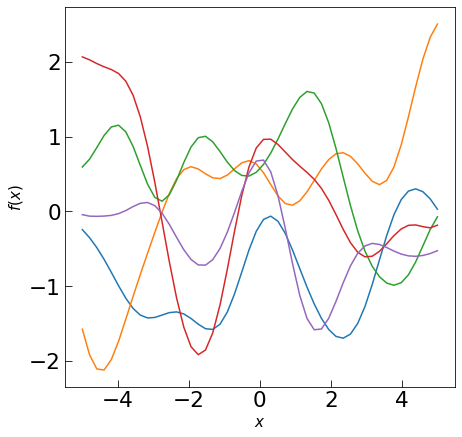

In [11]:
t = np.linspace(-5,5)
nsamples = 5
samples = gp.sample(t, nsamples) #this draws 6 samples from the GP prior with the kernel specified above
for n in range(nsamples):
  plt.plot(t, samples[n])
plt.xlabel("$x$")
plt.ylabel("$f(x)$")  

These functions are simply drawn from the Gaussian Process before being conditioned on any observations. You can think of these as samples from the prior probability over the function space. Here we have set the length scale to 1. Let's change the length scale and see how the samples look like!

Text(0, 0.5, '$f(x)$')

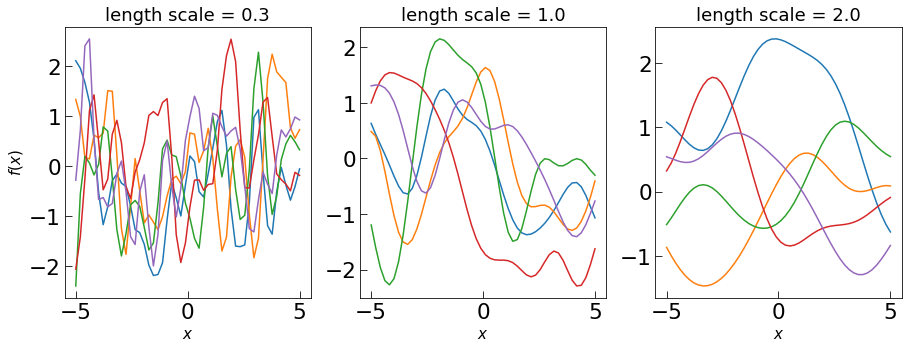

In [17]:
lengths = [0.09, 1, 4]
fig, ax = plt.subplots(nrows = 1, ncols =3, figsize = (15,5))
col = 0
for l in lengths:
  # Set up a Gaussian process
  kernel = ExpSquaredKernel(l)
  gp = george.GP(kernel)
  samples = gp.sample(t, nsamples) #this draws 6 samples from the GP prior with the kernel specified above
  for n in range(nsamples):
    ax[col].plot(t, samples[n])
    ax[col].set_xlabel("$x$")
    ax[col].set_title("length scale = "+str(l**.5))
  col += 1  
ax[0].set_ylabel("$f(x)$")

From these plots, it is evident that the lower the length scale, the more variations the sample have on smaller scales.

#Observations

So far, we have only discussed the distribution over functions. We have visualized some random samples from the prior distribution over functions before introducing any observation: $f \sim \mathcal N (0, K)$.

Now let's decompose the vector $f$ to $\Big(f(X_{\rm obs}), f(X_{\rm new})\Big)$, where $f(X_{\rm obs})$ is a vector containing the observed values of the function $f$ at the input locations $X_{\rm obs}$. Given that $f$ is drawn from a Gaussian distribution with the covariance K, we have:

$\begin{bmatrix}
f(X) \\
f(X_{\rm new}) 
\end{bmatrix} \sim \mathcal N \Big( \begin{bmatrix}
K(X_{\rm obs}, X_{\rm obs}) & K(X_{\rm obs}, X_{\rm new})\\
K(X_{\rm new}, X_{\rm obs}) & K(X_{\rm new}, X_{\rm new})) 
\end{bmatrix} \Big)$ 

Using the rules of Gaussian distribution marginalization, we can find the distribution of the function at the new points, where we have no observation:

$f(X_{\rm new}) \sim \mathcal{N}(\mu, \Sigma)$, where

$\mu = K(X_{\rm new}, X_{\rm obs}) K(X_{\rm obs}, X_{\rm obs})^{-1} f(X_{\rm obs})$, 

$\Sigma = K(X_{\rm new}, X_{\rm new}) - K(X_{\rm new}, X_{\rm obs}) K(X_{\rm obs}, X_{\rm obs})^{-1}K(X_{\rm obs}, X_{\rm new})$

These equations provide the best estimate and the variance of the function at the unobserved inputs $X_{\rm new}$.

Let's look at the following example:

In [0]:
def f(x):
  '''
  this the toy function that we use to 
  generate observed data points
  '''
  return np.tanh(x) + x/100.

np.random.seed(123)
xobs = np.random.uniform(-3, 3, 8)

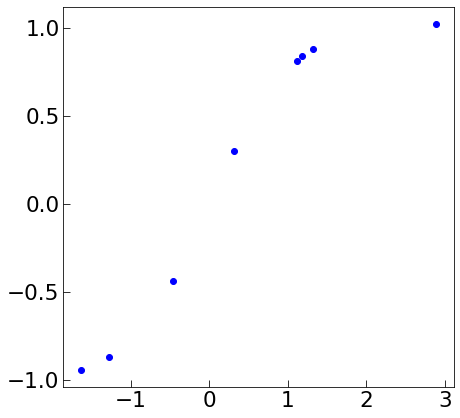

In [79]:
plt.plot(xobs, f(xobs) , "bo")

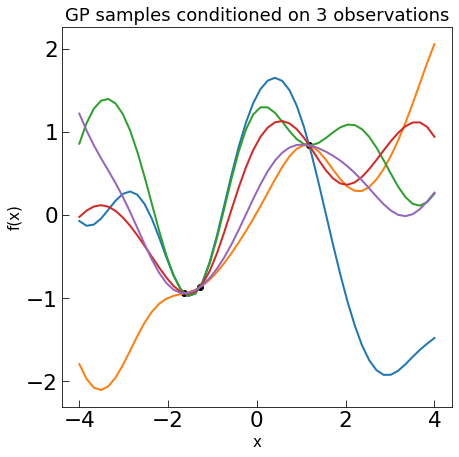

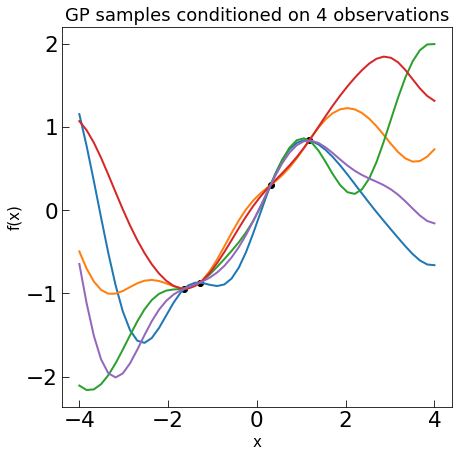

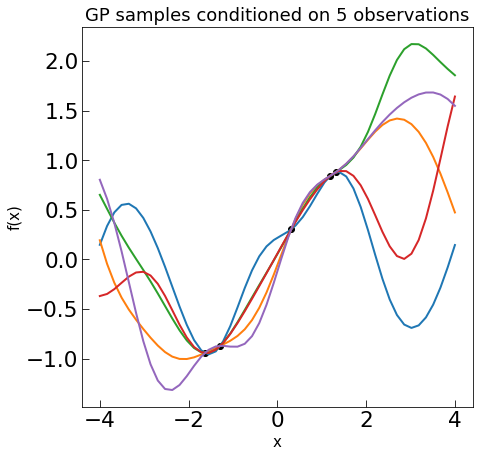

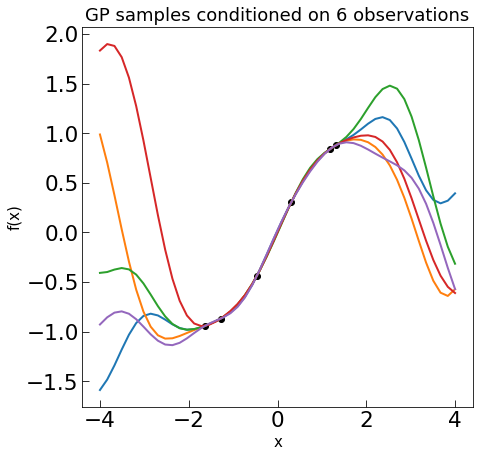

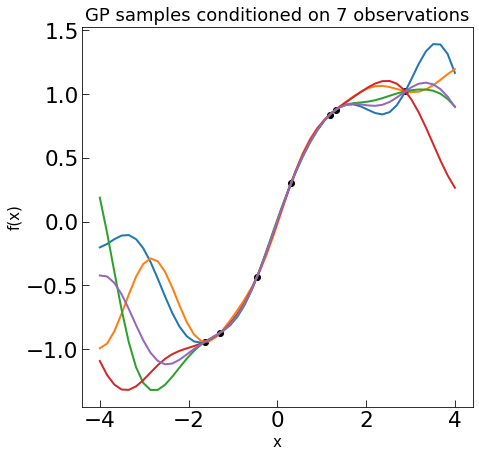

In [80]:
# length scale = 1
# Set up a Gaussian process
kernel = ExpSquaredKernel(1.0)
gp = george.GP(kernel)

for i in range(3, len(xobs)):
  #compute the kernel at the observed locations
  gp.compute(xobs[:i])
  #making a new set of test points
  xnew = np.linspace(-4, 4, 50)
  #number of samples
  nsamples = 5
  samples = gp.sample_conditional(f(xobs[:i]), xnew, nsamples)

  plt.plot(xobs[:i], f(xobs[:i]) , "ko")
  for n in range(nsamples):
    plt.plot(xnew, samples[n], lw = 2)
  plt.title("GP samples conditioned on "+str(i)+" observations")
  plt.xlabel("x")
  plt.ylabel("f(x)")  
  plt.show()

As seen in these figures, addtion of new observations will add more constraints to the inferred function. 

Furthermore, the uncertainty of the function in unobserved regions is high. This manifests itself in the large scatter between the samples drawn from the conditional probability. 

#What length scale should I use for the GP kernel?

Let's look at the above example again. 

Text(0, 0.5, '$f(x)$')

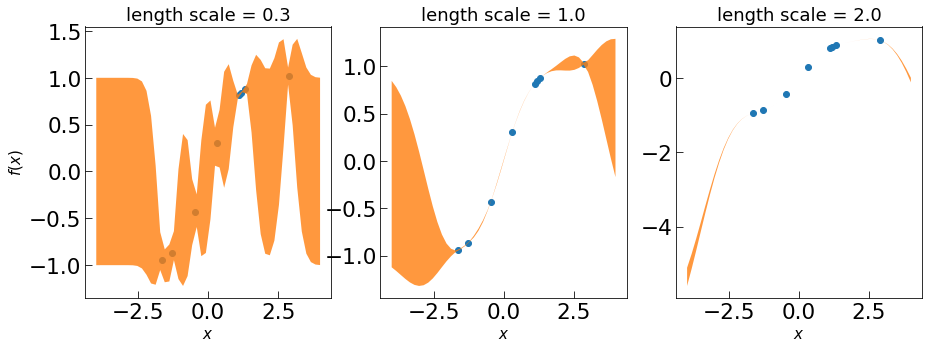

In [82]:
lengths = [0.09, 1, 4]
fig, ax = plt.subplots(nrows = 1, ncols =3, figsize = (15,5))
col = 0
for l in lengths:
  # Set up a Gaussian process
  kernel = ExpSquaredKernel(l)
  gp = george.GP(kernel)
  gp.compute(xobs)
  #the mean and covvariance of the function at xnew
  mean, covar = gp.predict(f(xobs), xnew)
  var = np.diag(covar)**.5
  ax[col].scatter(xobs, f(xobs))
  ax[col].fill_between(xnew, mean - var, mean + var, alpha = 0.8)
  ax[col].set_xlabel("$x$")
  ax[col].set_title("length scale = "+str(l**.5))
  col += 1  
ax[0].set_ylabel("$f(x)$")

#Hyperparameter optimization

In [87]:
y, t = f(xobs), xobs
import scipy.optimize as op

# Define the objective function (negative log-likelihood in this case).
def nll(p):
    gp.set_parameter_vector(p)
    ll = gp.log_likelihood(y, quiet=True)
    return -ll if np.isfinite(ll) else 1e25

# And the gradient of the objective function.
def grad_nll(p):
    gp.set_parameter_vector(p)
    return -gp.grad_log_likelihood(y, quiet=True)

# You need to compute the GP once before starting the optimization.
gp.compute(t)

# Print the initial ln-likelihood.
print(gp.log_likelihood(y))

# Run the optimization routine.
p0 = gp.get_parameter_vector()
results = op.minimize(nll, p0, jac=grad_nll, method="L-BFGS-B")

# Update the kernel and print the final log-likelihood.
gp.set_parameter_vector(results.x)
print(gp.log_likelihood(y))

-89.75604735859216
8.230795664410689


In [90]:
print("the optimal parameter=" , gp.get_parameter_vector())

the optimal parameter= [0.68823561]


Text(0, 0.5, '$f(x)$')

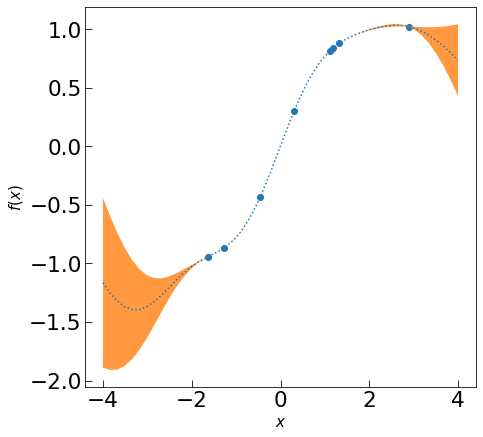

In [93]:
gp.compute(xobs)
#the mean and covvariance of the function at xnew
mean, covar = gp.predict(f(xobs), xnew)
#turn the cov to std
std = np.diag(covar)**.5
plt.scatter(xobs, f(xobs))
plt.plot(xnew, mean, ":")
plt.fill_between(xnew, mean - std, mean + std, alpha = 0.8)
plt.xlabel("$x$")
plt.ylabel("$f(x)$")

#Exercise:

Follow the example in [setting the hyper-parameters](http://dfm.io/george/current/user/hyper/) to get more familiar with the Gaussian Process regression and hyper parameter setting. Spoiler alert: this is the same example that we had in our previous notebook. 

Be aware that some of the lines in the parameter optimization block need to be updated in the following way:



(1) `gp.kernel[:] = p ` should be `gp.set_parameter_vector(p)`

(2) `p0 = gp.kernel.vector` should be `p0 = gp.get_parameter_vector()`

(3) `gp.kernel[:] = results.x` should be `gp.set_parameter_vector(results.x)`
